In [1]:
!pip3 install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Policy(nn.Module):
    def __init__(self, observation_space, action_space, hidden, learning_rate, gamma):
        super(Policy, self).__init__()
        self.data = []
        self.observation_space = observation_space
        self.action_space = action_space
        self.hidden = hidden
        self.fc1 = nn.Linear(self.observation_space, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.action_space)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.gamma = gamma

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

    def put_data(self, item):
        self.data.append(item)

    def get_reward(self, state):
        if state >= 0.5:
            return 10
        elif state > -0.4:
            return (1.0+state)**2
        else:
            return 0

    def train(self, device):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + self.gamma * R
            loss = -torch.log(prob).to(device) * R
            loss.backward()

        self.optimizer.step()
        self.data = []
        return loss.item()

Device:  cuda


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in 

*** New highscore! ***
episode: 0, score: 1.8956017358069026
*** New highscore! ***
episode: 1, score: 14.248401878783834
episode: 2, score: 4.89987884571279
episode: 3, score: 0.0
episode: 4, score: 8.009583143328427
episode: 5, score: 0.0
episode: 6, score: 3.314040934524596
episode: 7, score: 0.0
episode: 8, score: 0.0
episode: 9, score: 8.590995434705029
episode: 10, score: 0.0
episode: 11, score: 5.2063331348518975
episode: 12, score: 10.204155853174306
episode: 13, score: 0.0
*** New highscore! ***
episode: 14, score: 22.82207339613701
episode: 15, score: 0.0
episode: 16, score: 1.5099002422293628
*** New highscore! ***
episode: 17, score: 25.536903772433373
episode: 18, score: 0.0
episode: 19, score: 0.0
episode: 20, score: 16.77867234006277
episode: 21, score: 2.378987503171026
episode: 22, score: 8.591826017689415
episode: 23, score: 14.041256128180041
episode: 24, score: 4.892302218625599
episode: 25, score: 11.704523863581285
episode: 26, score: 10.47671815141107
episode: 27

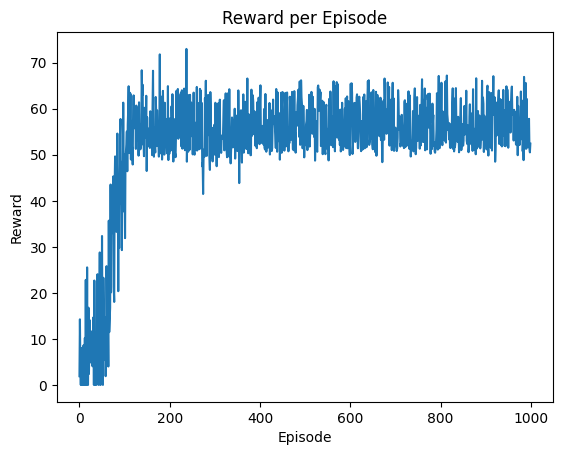

REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl
Video saved to: ./videos
To download the video, compress the video directory and download it manually.


In [ ]:
import gymnasium as gym
import torch
from collections import Counter
import matplotlib.pyplot as plt
from torch.distributions import Categorical
import pickle
import os
from gym.wrappers.record_video import RecordVideo

# hyperparameters
learning_rate = 0.002
gamma         = 0.99
hidden        = 128
episodes      = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

video_dir = "./videos"  # 비디오 저장 경로
os.makedirs(video_dir, exist_ok=True)

env = gym.make("MountainCar-v0", render_mode="rgb_array")
env = RecordVideo(env, video_dir, episode_trigger=lambda episode_id: True)
env._max_episode_steps = 200 # change steps limiit

# Get the obersvation space and the number of actions from the game.
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Define the model architecture
agent = Policy(observation_space, action_space, hidden, learning_rate, gamma).to(device)
scores = []
losses = []
actions = []

high_score = 0
for n_epi in range(episodes):
    observation, _ = env.reset()  # 수정된 부분: observation과 info를 분리
    done = False
    score = 0.0

    while not done:
        # observation을 torch 텐서로 변환하여 신경망에 전달
        prob = agent(torch.from_numpy(observation).float().to(device))
        m = Categorical(prob)
        action = m.sample()

        # step 결과를 다섯 개 변수로 받기
        step_result = env.step(action.item())
        if len(step_result) == 5:
            observation, reward, terminated, truncated, info = step_result
        else:
            observation, reward, terminated, info = step_result
            truncated = False

        done = terminated or truncated  # 종료 조건 수정

        new_reward = agent.get_reward(observation[0])  # 첫 번째 위치 값을 사용
        agent.put_data((new_reward, prob[action]))
        score += new_reward
        actions.append(action.item())

        # Render the game every 100 episodes
        if n_epi % 100 == 0:
            env.render()

    if score > high_score:
        print("*** New highscore! ***")
        high_score = score

    if done:
        scores.append(score)
        if 'TimeLimit.truncated' in info and info['TimeLimit.truncated']:
            response = 'Step limit maxed.'
        print("episode: {}, score: {}".format(n_epi, score))
        if observation[0] >= 0.5:  # 0.5 is the point of the flag!
            print('Success!')
            break

    losses.append(agent.train(device))

# Plot only the scores
plt.plot(scores)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

env.close()

with open("reinforce_scores.pkl", "wb") as f:
    pickle.dump(scores, f)
    print("REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl")

 # 비디오 다운로드 안내
    print(f"Video saved to: {video_dir}")
    print("To download the video, compress the video directory and download it manually.")

# 기존 DQN 방식에서 사용한 속도와 위치 기반 보상을 그대로 적용

# 락습률 0.002 --> 0.0005, 보상조정, env._max_episode_steps를 1000으로 설정

# env = RecordVideo(env, video_dir, episode_trigger=lambda episode_id: True) 이코드를 추가하면 성능이 떨어져 스코어가 낮게 나옴 비디오 저장 방법 변경

Device:  cuda
*** New highscore! ***
episode: 0, score: 237.6218936364869
*** New highscore! ***
episode: 1, score: 241.64901426017695
episode: 2, score: 240.23652731105312
episode: 3, score: 240.18100365170176
*** New highscore! ***
episode: 4, score: 243.0695676341117
episode: 5, score: 236.81026083065808
episode: 6, score: 238.9869320140117
episode: 7, score: 238.47890341986317
episode: 8, score: 239.96974393198093
episode: 9, score: 240.1506920668404
episode: 10, score: 235.62546752776535
episode: 11, score: 241.25577882543985
episode: 12, score: 242.75548517113566
episode: 13, score: 241.15868454341944
episode: 14, score: 239.66506079735882
*** New highscore! ***
episode: 15, score: 246.79700770448176
episode: 16, score: 240.98601075530587
episode: 17, score: 242.56111607325147
episode: 18, score: 236.7284672985271
episode: 19, score: 239.438980214004
episode: 20, score: 238.73025164613358
episode: 21, score: 237.73821660867816
*** New highscore! ***
episode: 22, score: 249.271726

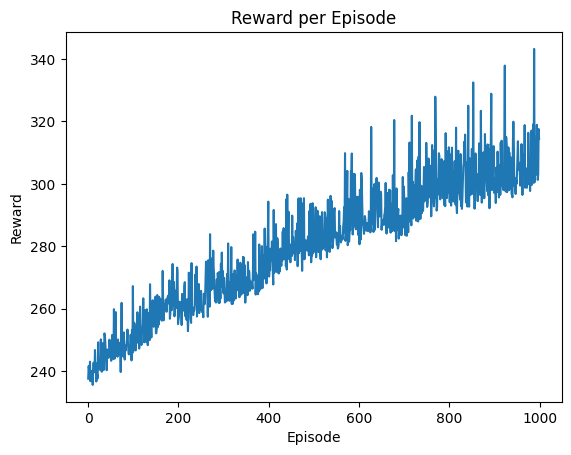

REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recorded Episode 0
Recorded Episode 1
Recorded Episode 2
Recorded Episode 3
Recorded Episode 4
Recorded Episode 5
Recorded Episode 6
Recorded Episode 7
Recorded Episode 8
Recorded Episode 9
Recorded Episode 10
Recorded Episode 11
Recorded Episode 12
Recorded Episode 13
Recorded Episode 14
Recorded Episode 15
Recorded Episode 16
Recorded Episode 17
Recorded Episode 18
Recorded Episode 19
Recorded Episode 20
Recorded Episode 21
Recorded Episode 22
Recorded Episode 23
Recorded Episode 24
Recorded Episode 25
Recorded Episode 26
Recorded Episode 27
Recorded Episode 28
Recorded Episode 29
Recorded Episode 30
Recorded Episode 31
Recorded Episode 32
Recorded Episode 33
Recorded Episode 34
Recorded Episode 35
Recorded Episode 36
Recorded Episode 37
Recorded Episode 38
Recorded Episode 39
Recorded Episode 40
Recorded Episode 41
Recorded Episode 42
Recorded Episode 43
Recorded Episode 44
Recorded Episode 45
Recorded Episode 46
Recorded Episode 47
Recorded Episode 48
Recorded Episode 49
Recorded E

In [ ]:
#import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pickle
import torch
import os
from gym.wrappers.record_video import RecordVideo

# Hyperparameters
learning_rate = 0.0005
gamma = 0.99
hidden = 128
episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

# Define Policy Network
class Policy(nn.Module):
    def __init__(self, observation_space, action_space, hidden, learning_rate, gamma):
        super(Policy, self).__init__()
        self.data = []
        self.fc1 = nn.Linear(observation_space, hidden)
        self.fc2 = nn.Linear(hidden, action_space)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.gamma = gamma

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

    def put_data(self, item):
        self.data.append(item)

    def train(self, device):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + self.gamma * R
            loss = -torch.log(prob).to(device) * R
            loss.backward()

        self.optimizer.step()
        self.data = []
        return loss.item()

# Initialize Environment
video_dir = "./reinforce_videos"
os.makedirs(video_dir, exist_ok=True)

# 학습용 환경
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env._max_episode_steps = 1000

# Get Observation Space and Action Space
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Initialize Policy
agent = Policy(observation_space, action_space, hidden, learning_rate, gamma).to(device)
scores = []
losses = []
actions = []

# DQN-style reward adjustment
def compute_reward(position, velocity, done):
    reward = 0
    if position >= 0.5:  # Goal reached
        reward += 100
    reward += abs(velocity) * 0.5  # Increase velocity contribution
    reward += abs(position) * 0.5  # Increase position contribution
    if done and position < 0.5:  # Penalize failure
        reward -= 20
    return reward

# Training loop
high_score = 0
for n_epi in range(episodes):
    observation, _ = env.reset()
    done = False
    score = 0.0

    while not done:
        prob = agent(torch.from_numpy(observation).float().to(device))
        m = Categorical(prob)
        action = m.sample()

        step_result = env.step(action.item())
        if len(step_result) == 5:
            observation, reward, terminated, truncated, info = step_result
        else:
            observation, reward, terminated, info = step_result
            truncated = False

        done = terminated or truncated

        # Compute adjusted reward
        position, velocity = observation  # Extract position and velocity
        new_reward = compute_reward(position, velocity, done)

        agent.put_data((new_reward, prob[action]))
        score += new_reward
        actions.append(action.item())

        if n_epi % 100 == 0:
            env.render()

    if score > high_score:
        print("*** New highscore! ***")
        high_score = score

    if done:
        scores.append(score)
        print("episode: {}, score: {}".format(n_epi, score))
        if observation[0] >= 0.5:  # Goal reached
            print('Success!')
            break

    losses.append(agent.train(device))


# Plot Results
plt.plot(scores)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

with open("reinforce_scores.pkl", "wb") as f:
    pickle.dump(scores, f)
    print("REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl")

video_env = RecordVideo(gym.make('MountainCar-v0', render_mode="rgb_array"), video_folder="./videos", episode_trigger=lambda e: True)
for episode in range(100):  # Record 5 episodes
    observation, _ = video_env.reset()
    done = False
    while not done:
        prob = agent(torch.from_numpy(observation).float().to(device))
        m = Categorical(prob)
        action = m.sample()
        observation, _, done, info = video_env.step(action.item())
    print(f"Recorded Episode {episode}")

video_env.close()
env.close()

In [ ]:
!zip -r videos.zip ./videos

updating: videos/ (stored 0%)
updating: videos/rl-video-episode-99.mp4 (deflated 11%)
updating: videos/rl-video-episode-85.meta.json (deflated 61%)
updating: videos/rl-video-episode-39.mp4 (deflated 16%)
updating: videos/rl-video-episode-7.meta.json (deflated 61%)
updating: videos/rl-video-episode-70.meta.json (deflated 61%)
updating: videos/rl-video-episode-90.mp4 (deflated 9%)
updating: videos/rl-video-episode-51.meta.json (deflated 61%)
updating: videos/rl-video-episode-0.meta.json (deflated 61%)
updating: videos/rl-video-episode-78.meta.json (deflated 61%)
updating: videos/rl-video-episode-93.meta.json (deflated 61%)
updating: videos/rl-video-episode-85.mp4 (deflated 10%)
updating: videos/rl-video-episode-65.meta.json (deflated 61%)
updating: videos/rl-video-episode-95.mp4 (deflated 10%)
updating: videos/rl-video-episode-40.meta.json (deflated 61%)
updating: videos/rl-video-episode-23.mp4 (deflated 15%)
updating: videos/rl-video-episode-24.mp4 (deflated 13%)
updating: videos/rl-vid

In [ ]:
from google.colab import files
files.download("videos.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# episode를 2000으로 늘려보기

Device:  cuda
*** New highscore! ***
episode: 0, score: 254.30557636396406
episode: 1, score: 250.77789659436803
episode: 2, score: 249.5286164701788
*** New highscore! ***
episode: 3, score: 257.60778654010403
episode: 4, score: 252.4431927581245
episode: 5, score: 248.29262993877398
episode: 6, score: 254.3232734399826
episode: 7, score: 255.94372698441566
episode: 8, score: 254.25126711702296
episode: 9, score: 254.2629691253751
episode: 10, score: 253.33820011149834
episode: 11, score: 255.6404660328053
episode: 12, score: 256.9679050947616
episode: 13, score: 256.45607495018044
*** New highscore! ***
episode: 14, score: 258.37456531923453
episode: 15, score: 256.83090307927614
episode: 16, score: 255.88966643961942
*** New highscore! ***
episode: 17, score: 258.462426093266
*** New highscore! ***
episode: 18, score: 262.5558677878694
episode: 19, score: 259.5933595054355
episode: 20, score: 258.9824157446528
episode: 21, score: 253.73226825030088
*** New highscore! ***
episode: 22

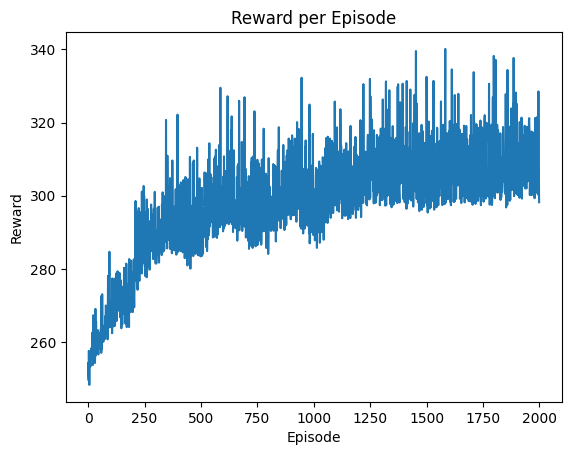

REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Recorded Episode 0
Recorded Episode 1
Recorded Episode 2
Recorded Episode 3
Recorded Episode 4
Recorded Episode 5
Recorded Episode 6
Recorded Episode 7
Recorded Episode 8
Recorded Episode 9
Recorded Episode 10
Recorded Episode 11
Recorded Episode 12
Recorded Episode 13
Recorded Episode 14
Recorded Episode 15
Recorded Episode 16
Recorded Episode 17
Recorded Episode 18
Recorded Episode 19
Recorded Episode 20
Recorded Episode 21
Recorded Episode 22
Recorded Episode 23
Recorded Episode 24
Recorded Episode 25
Recorded Episode 26
Recorded Episode 27
Recorded Episode 28
Recorded Episode 29
Recorded Episode 30
Recorded Episode 31
Recorded Episode 32
Recorded Episode 33
Recorded Episode 34
Recorded Episode 35
Recorded Episode 36
Recorded Episode 37
Recorded Episode 38
Recorded Episode 39
Recorded Episode 40
Recorded Episode 41
Recorded Episode 42
Recorded Episode 43
Recorded Episode 44
Recorded Episode 45
Recorded Episode 46
Recorded Episode 47
Recorded Episode 48
Recorded Episode 49
Recorded E

In [3]:
#import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pickle
import torch
import os
from gym.wrappers.record_video import RecordVideo

# Hyperparameters
learning_rate = 0.0005
gamma = 0.99
hidden = 128
episodes = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

# Define Policy Network
class Policy(nn.Module):
    def __init__(self, observation_space, action_space, hidden, learning_rate, gamma):
        super(Policy, self).__init__()
        self.data = []
        self.fc1 = nn.Linear(observation_space, hidden)
        self.fc2 = nn.Linear(hidden, action_space)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.gamma = gamma

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

    def put_data(self, item):
        self.data.append(item)

    def train(self, device):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + self.gamma * R
            loss = -torch.log(prob).to(device) * R
            loss.backward()

        self.optimizer.step()
        self.data = []
        return loss.item()

# Initialize Environment
video_dir = "./reinforce_videos"
os.makedirs(video_dir, exist_ok=True)

# 학습용 환경
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env._max_episode_steps = 1000

# Get Observation Space and Action Space
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

# Initialize Policy
agent = Policy(observation_space, action_space, hidden, learning_rate, gamma).to(device)
scores = []
losses = []
actions = []

# DQN-style reward adjustment
def compute_reward(position, velocity, done):
    reward = 0
    if position >= 0.5:  # Goal reached
        reward += 100
    reward += abs(velocity) * 0.5  # Increase velocity contribution
    reward += abs(position) * 0.5  # Increase position contribution
    if done and position < 0.5:  # Penalize failure
        reward -= 20
    return reward

# Training loop
high_score = 0
for n_epi in range(episodes):
    observation, _ = env.reset()
    done = False
    score = 0.0

    while not done:
        prob = agent(torch.from_numpy(observation).float().to(device))
        m = Categorical(prob)
        action = m.sample()

        step_result = env.step(action.item())
        if len(step_result) == 5:
            observation, reward, terminated, truncated, info = step_result
        else:
            observation, reward, terminated, info = step_result
            truncated = False

        done = terminated or truncated

        # Compute adjusted reward
        position, velocity = observation  # Extract position and velocity
        new_reward = compute_reward(position, velocity, done)

        agent.put_data((new_reward, prob[action]))
        score += new_reward
        actions.append(action.item())

        if n_epi % 100 == 0:
            env.render()

    if score > high_score:
        print("*** New highscore! ***")
        high_score = score

    if done:
        scores.append(score)
        print("episode: {}, score: {}".format(n_epi, score))
        if observation[0] >= 0.5:  # Goal reached
            print('Success!')
            break

    losses.append(agent.train(device))

# Plot Results
plt.plot(scores)
plt.title('Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

with open("reinforce_scores.pkl", "wb") as f:
    pickle.dump(scores, f)
    print("REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl")

video_env = RecordVideo(gym.make('MountainCar-v0', render_mode="rgb_array"), video_folder="./videos", episode_trigger=lambda e: True)
for episode in range(1000):
    observation, _ = video_env.reset()
    done = False
    while not done:
        prob = agent(torch.from_numpy(observation).float().to(device))
        m = Categorical(prob)
        action = m.sample()
        observation, _, done, info = video_env.step(action.item())
    print(f"Recorded Episode {episode}")

video_env.close()
env.close()

In [4]:
!zip -r videos.zip ./videos

  adding: videos/ (stored 0%)
  adding: videos/rl-video-episode-340.meta.json (deflated 61%)
  adding: videos/rl-video-episode-99.mp4 (deflated 10%)
  adding: videos/rl-video-episode-585.mp4 (deflated 10%)
  adding: videos/rl-video-episode-892.meta.json (deflated 61%)
  adding: videos/rl-video-episode-809.meta.json (deflated 61%)
  adding: videos/rl-video-episode-85.meta.json (deflated 61%)
  adding: videos/rl-video-episode-139.mp4 (deflated 15%)
  adding: videos/rl-video-episode-412.meta.json (deflated 61%)
  adding: videos/rl-video-episode-757.meta.json (deflated 61%)
  adding: videos/rl-video-episode-794.meta.json (deflated 61%)
  adding: videos/rl-video-episode-736.mp4 (deflated 10%)
  adding: videos/rl-video-episode-39.mp4 (deflated 12%)
  adding: videos/rl-video-episode-350.meta.json (deflated 61%)
  adding: videos/rl-video-episode-497.meta.json (deflated 61%)
  adding: videos/rl-video-episode-909.mp4 (deflated 10%)
  adding: videos/rl-video-episode-898.mp4 (deflated 9%)
  adding

In [5]:
from google.colab import files
files.download("videos.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 테스트

Device:  cuda
*** New highscore! ***
episode: 0, score: 25.646951573929663
episode: 1, score: 20.91184529767136
episode: 2, score: 3.7425518687268777
episode: 3, score: 8.907480516994923
episode: 4, score: 3.258508903945767
episode: 5, score: 7.896953942051215
episode: 6, score: 17.368923898048987
episode: 7, score: 13.458693496517391
*** New highscore! ***
episode: 8, score: 33.47979170766234
episode: 9, score: 8.801201259205506
episode: 10, score: 2.2651288323253027
episode: 11, score: 2.9406873726561855
episode: 12, score: 12.348618585051415
episode: 13, score: 2.8851748346323802
episode: 14, score: 9.25654033535291
episode: 15, score: 3.5976344765822432
episode: 16, score: 9.582754715032454
episode: 17, score: 31.78415898983993
episode: 18, score: 3.5568135149742375
episode: 19, score: 4.734661230909296
episode: 20, score: 9.89244230518512
*** New highscore! ***
episode: 21, score: 42.83125549128409
episode: 22, score: 5.718859262524347
episode: 23, score: 16.13518185788784
episode

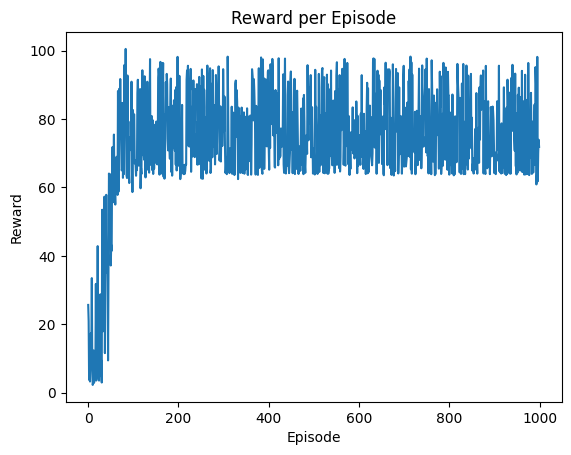

REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym
import matplotlib.pyplot as plt
import pickle


class Policy(nn.Module):
    def __init__(self, observation_space, action_space, hidden, learning_rate, gamma):
        super(Policy, self).__init__()
        self.data = []
        self.observation_space = observation_space
        self.action_space = action_space
        self.hidden = hidden
        self.fc1 = nn.Linear(self.observation_space, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.action_space)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.gamma = gamma

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=0)
        return x

    def put_data(self, item):
        self.data.append(item)

    def get_reward(self, state, velocity):
        # 목표 위치 도달 시 큰 보상
        if state >= 0.5:
            return 100
        # 시작점보다 오른쪽으로 이동
        elif state > -0.4:
            return (1.0 + state) ** 2 + abs(velocity) * 10
        # 기본 보상 (속도 기반 추가)
        else:
            return abs(velocity) * 5

    def train(self, device):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + self.gamma * R
            loss = -torch.log(prob).to(device) * R
            loss.backward()

        self.optimizer.step()
        self.data = []
        return loss.item()


def main():
    # Hyperparameters
    learning_rate = 0.005
    gamma = 0.99
    hidden = 128
    episodes = 1000

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Device: ', device)

    # Create environment
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    env._max_episode_steps = 250  # Change step limit

    # Get the observation space and the number of actions from the game
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n

    # Define the model architecture
    agent = Policy(observation_space, action_space, hidden, learning_rate, gamma).to(device)
    scores = []
    losses = []
    actions = []

    high_score = 0
    for n_epi in range(episodes):
        observation, _ = env.reset()  # Reset the environment
        done = False
        score = 0.0

        while not done:
            # Convert observation to torch tensor and pass through the network
            prob = agent(torch.from_numpy(observation).float().to(device))
            m = Categorical(prob)
            action = m.sample()

            # Step results
            step_result = env.step(action.item())
            if len(step_result) == 5:
                observation, reward, terminated, truncated, info = step_result
            else:
                observation, reward, terminated, info = step_result
                truncated = False

            done = terminated or truncated  # Adjust termination condition

            # Calculate custom reward using position and velocity
            new_reward = agent.get_reward(observation[0], observation[1])
            agent.put_data((new_reward, prob[action]))
            score += new_reward
            actions.append(action.item())

            # Render the game every 100 episodes
            if n_epi % 100 == 0:
                env.render()

        if score > high_score:
            print("*** New highscore! ***")
            high_score = score

        if done:
            scores.append(score)
            if 'TimeLimit.truncated' in info and info['TimeLimit.truncated']:
                response = 'Step limit maxed.'
            print("episode: {}, score: {}".format(n_epi, score))
            if observation[0] >= 0.5:  # 0.5 is the point of the flag!
                print('Success!')
                break

        losses.append(agent.train(device))

    # Plot only the scores
    plt.plot(scores)
    plt.title('Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    env.close()

    # Save the results
    with open("reinforce_scores.pkl", "wb") as f:
        pickle.dump(scores, f)
        print("REINFORCE 학습 결과 저장 완료: reinforce_scores.pkl")


if __name__ == "__main__":
    main()